# Skimmable Papers Abstracts

## Importing Libraries

In [1]:
from helper_functions import *
import pathlib
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, TextVectorization
from tensorflow.keras import Sequential
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow_datasets as tfds
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\Tomy\anaconda3.1\envs\deeplearning-GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-572fe43f-9874-821c-8a5f-e3f1cd3905b6)


## 1. Finding the Data

We are goint to replicate the paper "PubMed 200k RCT", let's download the dataset from:
https://github.com/Franck-Dernoncourt/pubmed-rct/tree/master

In [3]:
# Download the data from the github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
%ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


 El volumen de la unidad C no tiene etiqueta.
 El número de serie del volumen es: 9E0C-BC7B

 Directorio de C:\Users\Tomy\TensorFLow\pubmed-rct

29/02/2024  08:25 am    <DIR>          .
29/02/2024  08:25 am    <DIR>          ..
29/02/2024  08:25 am    <DIR>          PubMed_200k_RCT
29/02/2024  08:25 am    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
29/02/2024  08:25 am    <DIR>          PubMed_20k_RCT
29/02/2024  08:25 am    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
29/02/2024  08:25 am             3,733 README.md
               1 archivos          3,733 bytes
               6 dirs  24,890,753,024 bytes libres


In [4]:
# Start our experiment using the 20k dataset with number replace by a @ sing
data_dir = "pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\"

In [5]:
# Check all the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\test.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt']

## 2. Prepare our Data

### Read all the data set

In [6]:
# First we need to write a function to read in all of the lines of a target text file
def read(filename):
    with open(filename, "r") as text:
        return text.readlines()
    
    

In [7]:
train = read('pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt')
train[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

### Separate our data into labels and sentences

In [8]:
# We can create a dictionary that separe all the content into key values
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    """
    input_lines = read(filename)
    abstract_lines = ""
    abstract_samples = []
    
    #Loop through each line in the target file
    for line in input_lines:
        # If is the ID only
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = '' #This reset the list if this line is an ID line
            
        # IF the line is just a empy space then: line = '\n'
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() #Split the abstract into separate lines

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t') # Split in tab spaces then separate (label and text)
                line_data['line_number'] = abstract_line_number # what number line is
                line_data['target'] = target_text_split[0] # Get the label
                line_data['text'] = target_text_split[1].lower() # Get the text
                line_data['total_lines'] = len(abstract_line_split) -1
                abstract_samples.append(line_data)

        # This captures the whole abstract until it comes to and empy space line
        else:
            abstract_lines += line

    return abstract_samples

In [9]:

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: total: 844 ms
Wall time: 877 ms


(180040, 30212, 30135)

In [10]:
train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

### Convert the data to a DataFrame

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [12]:
train_df.target.value_counts() 

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

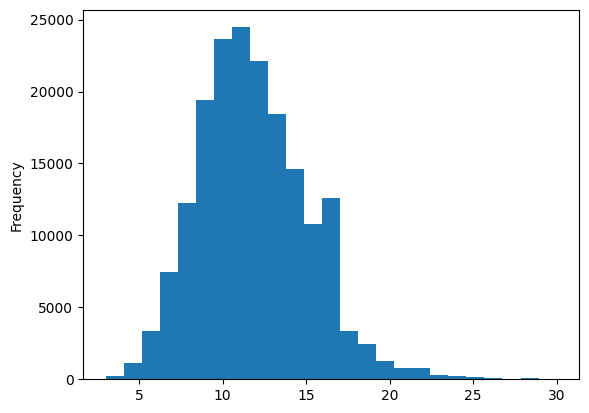

In [13]:
train_df.total_lines.plot.hist(bins=25)

### Get a list of sentences

In [14]:
#Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences)

180040

### Get our labels to OneHot Encoder

In [15]:
# Using OneHotEnconder
one_hot_encoder = OneHotEncoder(sparse_output=False) # Set a container for our classes
train_labels_onehot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_onehot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_onehot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))

train_labels_onehot[0]

array([0., 0., 0., 1., 0.])

### Encode labels to numbers


In [16]:
# Encode our labels into integers

label_encoder = LabelEncoder() # Set a container for our classes
train_label_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_label_encoded = label_encoder.transform(val_df.target.to_numpy())
test_label_encoded = label_encoder.transform(test_df.target.to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get the class names
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## 3. Building Models

### Model 0: Base-Line

In [18]:
# Create a pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()), # Tokenize our sentences
    ("clf", MultinomialNB()) # Export to multiclass form
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# Evaluate our Baseline model
model_0.score(X = val_sentences,  # Accuracy score
              y = val_label_encoded)

0.7218323844829869

In [20]:
# Make a prediction using our baseline
baseline_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(y_true = val_label_encoded,
                                     y_pred = baseline_preds)

baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Prepare our data for deep sequence models

In [21]:
# How long is the average of our sentencens
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

avg_sent_len


26.338269273494777

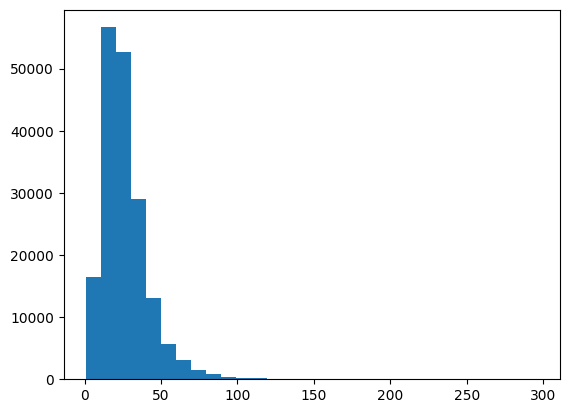

In [22]:
# How is the distribution of the data?
plt.hist(sent_lens, bins=30);

We have some values over 60, so maybe those are outliers

In [23]:
# how lond of a sentence lenght covers 90% of examples
output_seq_len = int(np.percentile(sent_lens, 90))
output_seq_len

45

#### Create a text vectorizer

In [24]:
# Fisrt we need to define our max words in our vocabulary (|V|)
max_tokens = 68000 # Acord to Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000.

# Create the text vectorizer
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                   output_sequence_length=output_seq_len)

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [25]:
# Test out text vectorizer
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
in this randomised , double-blind , placebo-controlled , parallel-group , phase @ trial done in @ hospitals in mainland china , hong kong , south korea , taiwan , and vietnam , we recruited asian patients aged @ years or older with progressive metastatic colorectal cancer who had received at least two previous treatment lines or were unable to tolerate standard treatments .

Length of text: 63

Vectorized text:
[[    5    23   210   236   329  1316   209    32  1223     5  1054     5
  13183  1709  7685  7671  1843  5066  7437     3  8331    43   404  2353
     12   307    64    16   350     7  1754  1321  1264   135    67    55
     80    15   322    51   468    19  3598    16     9]]


In [26]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [27]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 45,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [28]:
# Embedding
embedding = layers.Embedding(input_dim=max_tokens, output_dim= 128,
                            input_length=output_seq_len,
                            mask_zero=True)
embedding

#### Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loadingbatches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [29]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [30]:

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Simple Conv1D

In [31]:
# Build the model 

inputs = layers.Input(shape=(1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x) 
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "Model_1_Conv")

# Compile Convolutional model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "Model_1_Conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 45)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 45, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 45, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                

In [32]:
# Fit model
model_1_history = model_1.fit(train_dataset,
                              epochs=2,
                              validation_data=(valid_dataset),
                              callbacks=[create_tensorboard_callback('traning_logs\\', "Conv")])

Saving TensorBoard log files to: traning_logs\\Conv\20240304-101519
Epoch 1/2
5627/5627 [==============================] - 56s 9ms/step - loss: 0.2262 - accuracy: 0.7712 - val_loss: 0.1977 - val_accuracy: 0.8083
Epoch 2/2
5627/5627 [==============================] - 48s 9ms/step - loss: 0.1737 - accuracy: 0.8385 - val_loss: 0.1937 - val_accuracy: 0.8145


In [33]:
model_1_pred_probs = model_1.predict(valid_dataset)

model_1_pred = tf.argmax(model_1_pred_probs, axis= 1)
model_1_results = calculate_results(y_true= val_label_encoded,
                                   y_pred = model_1_pred)
model_1_results

945/945 [==============================] - 3s 3ms/step


{'accuracy': 81.45438898450946,
 'precision': 0.8122349850715203,
 'recall': 0.8145438898450946,
 'f1': 0.811095761642101}

### Model 2: Pre-trained Model

In [34]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
with tf.device('/CPU:0'):
    tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")
        
    # Test out the embedding on a random sentence
    random_training_sentence = random.choice(train_sentences)
    print(f"Random training sentence:\n{random_training_sentence}\n")
    use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
    print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
    print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
intraoperative blood pressure and heart rate were more stable with pnbs ( p < @ ) .

Sentence after embedding:
[-0.03863185 -0.00919534  0.02348929  0.01298719  0.03732745 -0.05730108
  0.07156441 -0.04662018  0.04286718  0.02687445  0.08362947 -0.03277813
  0.02911945 -0.08260288  0.03801676 -0.04662736 -0.08886987  0.01402348
  0.03830442  0.05652914  0.03773173 -0.01260483  0.01431117  0.01156898
 -0.0397672  -0.00552285 -0.02595433  0.01652098 -0.03799811 -0.03316488] (truncated output)...

Length of sentence embedding:
512


In [35]:
# Create model 2

model_2 = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    tf_hub_embedding_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation= "softmax") # Softmax is for working with more than 2 classes
])

model_2.compile(loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
                optimizer='adam',                         # Optimizador Adam
                metrics=['accuracy'])    

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [36]:
# Fit model
with tf.device('/CPU:0'): # Use this just for the bug
    model_2_history = model_2.fit(train_dataset,
                                  steps_per_epoch=int(0.1 * len(train_dataset)),
                                  epochs=5,
                                  validation_data=(valid_dataset),
                                  validation_steps=int(0.1 * len(valid_dataset)))
                                  

Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9151 - accuracy: 0.6520 - val_loss: 0.7982 - val_accuracy: 0.6865
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7701 - accuracy: 0.7010 - val_loss: 0.7563 - val_accuracy: 0.7028
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7542 - accuracy: 0.7123 - val_loss: 0.7409 - val_accuracy: 0.7138
Epoch 4/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7197 - accuracy: 0.7231 - val_loss: 0.7133 - val_accuracy: 0.7281
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7284 - accuracy: 0.7215 - val_loss: 0.6911 - val_accuracy: 0.7324


In [37]:
with tf.device('/CPU:0'):
     model_2_pred_probs = model_2.predict(valid_dataset)
    

945/945 [==============================] - 9s 9ms/step


In [38]:
model_2_pred = tf.argmax(model_2_pred_probs, axis= 1)
model_2_results = calculate_results(y_true= val_label_encoded,
                                   y_pred = model_2_pred)
model_2_results

{'accuracy': 73.41784721302793,
 'precision': 0.7307337293503224,
 'recall': 0.7341784721302793,
 'f1': 0.7286328020155372}

### Model 3: Conv1D with character embeddings

#### Create a character-level tokenizer

In [39]:
# make a funtion to split stences into chars
def split_chars(text):
    return " ".join(list(text))


In [40]:
# Split sequence-level data splits into character-level data split
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [41]:
train_chars[0], train_sentences[0]

('t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .')

In [42]:
# what is the average character lenght
char_len = [len(sentence) for sentence in train_sentences]
char_len_mean = np.mean(char_len)

char_len_mean

149.3662574983337

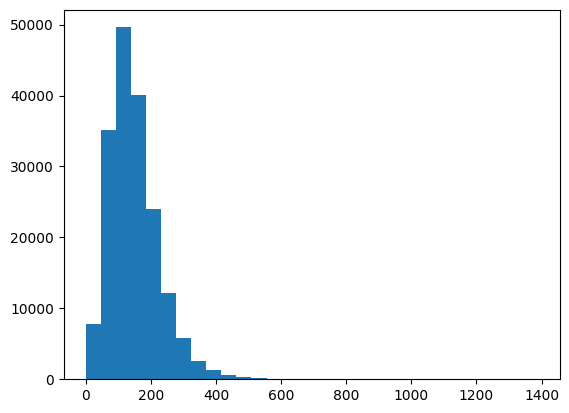

In [43]:
# look at the distribution of the character lenght
plt.hist(char_len, bins= 30);

In [44]:
char_len_90 = np.percentile(char_len, 90)

char_len_90

247.0

In [45]:
# What is our lenght of vocab now? with characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation

total_alphabet = len(alphabet) + 2 # 2 for space and OOV token

In [46]:
# Create a character vectorizer

char_vectorizer = TextVectorization(max_tokens=total_alphabet, output_sequence_length= int(char_len_90),
                                    name = "char_vectorizer")
char_vectorizer.adapt(train_chars)

In [47]:
# Check our character vecotrizer vocabulary
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
char_vocab[:5] # most commmon charcters


28


['', '[UNK]', 'e', 't', 'i']

In [48]:
# Create a Character Embedding Layer
char_embedding = layers.Embedding(input_length=char_len_90, output_dim=25,  # This is the size of the char embedding used in the paper pubmed 200k rct
                                  input_dim = total_alphabet, mask_zero=True, name = 'char_embed')

#### Create our dataset of chars

In [49]:
# Turn our data into TensorFlow Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Build the model 3

In [50]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype = tf.string, name = 'token_input')
token_embdedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embdedding)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

# 2. Setup chat inputs/model
char_inputs = layers.Input(shape=[1,], dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs = char_ltsm)

# 3. Concatenate token and char embeddings

token_char_concat = layers.Concatenate(name="Concatenate")([token_model.output, char_model.output])

#  4. Create outputs layers in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat) # Helps to prevent overfitting
combined_dense = layers.Dense(128, activation= 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct the model with char and token inputs

model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                                 outputs = output_layer, name='Model_3_tokenandchars')


In [51]:
# Compile our model 3
model_3.compile(loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
                optimizer='adam',                         # Optimizador Adam
                metrics=['accuracy'])

In [52]:
model_3.summary()

Model: "Model_3_tokenandchars"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 247)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input

#### Visualize complex models

In [ ]:
# plot the model 
from keras.utils import plot_model
plot_model(model_2)

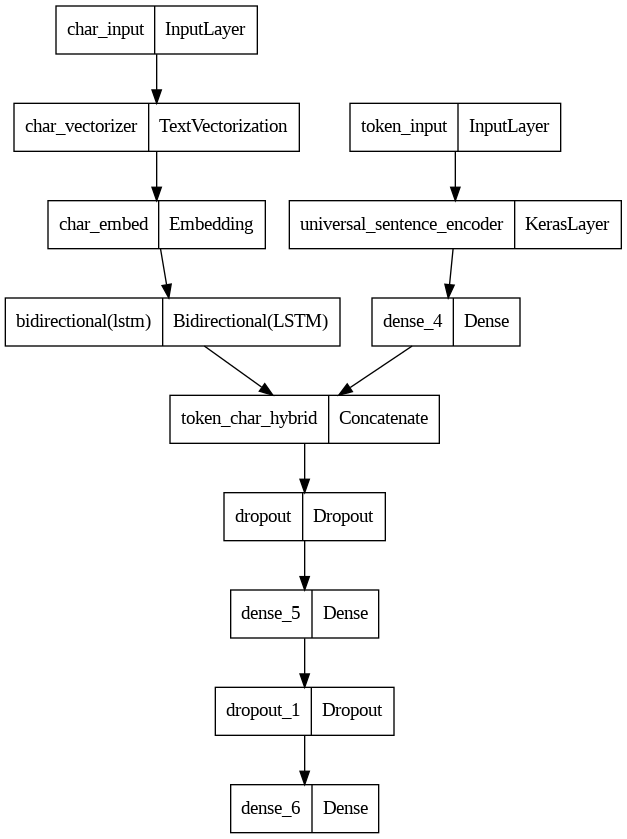

In [54]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [55]:
with tf.device('/CPU:0'):
# Fit the model on tokens and chars
    model_3_history = model_3.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 81s 130ms/step - loss: 0.9859 - accuracy: 0.6027 - val_loss: 0.7779 - val_accuracy: 0.6975
Epoch 2/5
562/562 [==============================] - 69s 122ms/step - loss: 0.7972 - accuracy: 0.6921 - val_loss: 0.7174 - val_accuracy: 0.7277
Epoch 3/5
562/562 [==============================] - 69s 123ms/step - loss: 0.7777 - accuracy: 0.7021 - val_loss: 0.6951 - val_accuracy: 0.7357
Epoch 4/5
562/562 [==============================] - 72s 129ms/step - loss: 0.7415 - accuracy: 0.7219 - val_loss: 0.6666 - val_accuracy: 0.7500
Epoch 5/5
562/562 [==============================] - 69s 123ms/step - loss: 0.7494 - accuracy: 0.7165 - val_loss: 0.6608 - val_accuracy: 0.7470


### Model 4: Feature Engineering - Positional embedding

#### Create positional embeddings

We need to encode our positional arguments (line_number/total_lines), selecting the coverage of each one accord to the distribution

In [78]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [79]:

train_lines_onehot = tf.one_hot(train_df.line_number.to_numpy(), depth = 15) # !5 is for the distribution the 95% is less that 15 lines long
val_lines_onehot = tf.one_hot(val_df.line_number.to_numpy(), depth = 15)
test_lines_onehot = tf.one_hot(test_df.line_number.to_numpy(), depth = 15)
train_lines_onehot.shape

TensorShape([180040, 15])

In [80]:
train_df.total_lines.value_counts()
train_totalline_onehot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 20) # !5 is for the distribution the 95% is less that 15 lines long
val_totalline_onehot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 20)
test_totalline_onehot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)
train_totalline_onehot.shape

TensorShape([180040, 20])

#### Creating the tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number"
4. Create a model for the "total_lines"
5. Combine the outputs of 1 & 2 using Concatenate from keras
6. Combine the outputs of 3, 4 ,5 using Concatenate from keras
7. Create an output layer to accept the tribbried embdedding ans output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a tf.keras.Model

In [84]:
# 1. Setup token inputs/model (Transfer learning)
token_inputs = layers.Input(shape=[], dtype = tf.string, name = 'token_input')
token_embdedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embdedding)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

# 2. Setup chars inputs/model (custom model)
char_inputs = layers.Input(shape=[1,], dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs = char_ltsm)

# 3. Create a model for the "line_number"

line_input = layers.Input(shape=[15,], dtype = tf.float32, name="line_input")
line_output = layers.Dense(32, activation="relu")(line_input)
line_model = tf.keras.Model(inputs=line_input, outputs=line_output)

# 4. Create a model for the "total_lines"

total_input = layers.Input(shape=[20,], dtype = tf.float32, name="total_input")
total_output = layers.Dense(32, activation="relu")(total_input)
total_model = tf.keras.Model(inputs=total_input, outputs=total_output)


# 5 Combine the outputs of 1 & 2 using Concatenate from keras

token_char_concat = layers.Concatenate(name="Concatenate")([token_model.output, char_model.output])

# Dropout layer 
combined_dropout = layers.Dropout(0.5)(token_char_concat) # Helps to prevent overfitting
combined_dense = layers.Dense(128, activation= 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)



# 6 Combine the outputs of 3, 4 ,5 using Concatenate from keras

tribrid_embedding = layers.Concatenate(name='tribrid_positional_embedding')([line_model.output, total_model.output, final_dropout])

# 7 Create a outputlayer
output_layer = layers.Dense(5, activation="softmax")(tribrid_embedding)

# 8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a tf.keras.Model

model_4 = tf.keras.Model(inputs=[line_model.input, total_model.input, token_model.input, char_model.input],
                                 outputs = output_layer, name='Model_4_complex')

model_4.summary()

Model: "Model_4_complex"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 247)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]

#### Plot the model

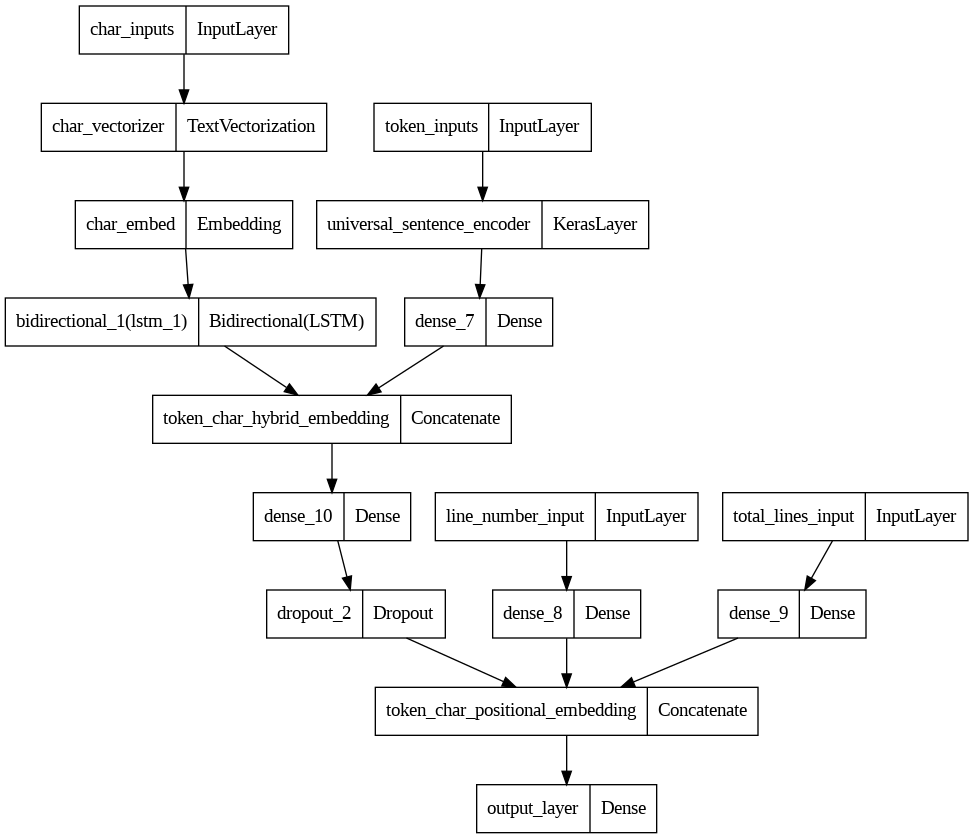

New parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

In [85]:
# Compile our model 3
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # Help prevent overfitting
                optimizer='adam',                         # Optimizador Adam
                metrics=['accuracy'])

#### Creating the datasets

In [87]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_lines_onehot, train_totalline_onehot, train_sentences, train_chars)) # Same order that model above model_4 = tf.keras.Model(inputs= ....)
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_lines_onehot, val_totalline_onehot, val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
with tf.device('/CPU:0'):
# Fit the model on tokens and chars
    model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 85s 134ms/step - loss: 1.1353 - accuracy: 0.6991 - val_loss: 0.9928 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 71s 127ms/step - loss: 0.9938 - accuracy: 0.7964 - val_loss: 0.9588 - val_accuracy: 0.8221
Epoch 3/3
562/562 [==============================] - 72s 128ms/step - loss: 0.9774 - accuracy: 0.8065 - val_loss: 0.9502 - val_accuracy: 0.8285


In [ ]:
with tf.device('/CPU:0'):
    model_4_pred_probs = model_4.predict(val_char_token_dataset)
    
    

In [97]:
model_4_pred = tf.argmax(model_4_pred_probs, axis= 1)
model_4_results = calculate_results(y_true= val_label_encoded,
                                       y_pred = model_4_pred)
model_4_results

{'accuracy': 82.64596848934198,
 'precision': 0.8248843856808074,
 'recall': 0.8264596848934198,
 'f1': 0.8254382314176976}

## Compare our Models result

In [103]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "conv1d": model_1_results,
                                  "Hybrid_token_embed": model_2_results,
                                  "Tribrid_char_token_embed": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
conv1d,81.454389,0.812235,0.814544,0.811096
Hybrid_token_embed,73.417847,0.730734,0.734178,0.728633
Tribrid_char_token_embed,82.645968,0.824884,0.826460,0.825438


<Axes: >

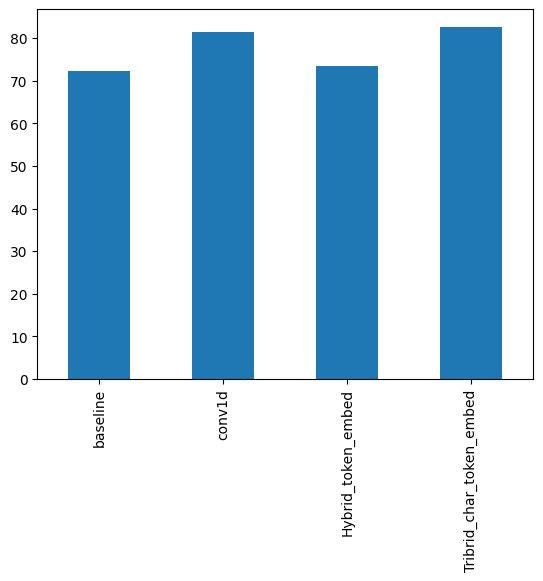

In [106]:
all_model_results.accuracy.plot(kind="bar")

## Save our best model

In [108]:
# Save best performing model to SavedModel format (default)
model_4.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


## Try our model

In [115]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_lines_onehot,
                                                               test_totalline_onehot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [117]:
# Make predictions on the test dataset
with tf.device('/CPU:0'):
    test_pred_probs = model_4.predict(test_pos_char_token_dataset,
                                           verbose=1)
    test_preds = tf.argmax(test_pred_probs, axis=1)
    test_preds[:10]

942/942 [==============================] - 27s 28ms/step


In [118]:


%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: total: 14.6 s
Wall time: 14 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESUL

In [119]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)
     

,line_number,target,text,total_lines,prediction,pred_prob,correct
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,OBJECTIVE,0.491657,False
1,1,RESULTS,a post hoc analysis was conducted with the use...,8,OBJECTIVE,0.358226,False
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8,METHODS,0.732657,False
3,3,RESULTS,survival analyses were used to assess the asso...,8,METHODS,0.602157,False
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8,RESULTS,0.677940,True
5,5,RESULTS,when mean hemodynamic profiles were compared i...,8,RESULTS,0.880029,True
6,6,RESULTS,multivariable analyses revealed that patients ...,8,RESULTS,0.487804,True
7,7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,8,CONCLUSIONS,0.396122,True
8,8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,RESULTS,0.459835,False
9,0,BACKGROUND,minimally invasive endovascular aneurysm repai...,12,BACKGROUND,0.531818,True


In [125]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [127]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [128]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [129]:

# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [130]:

# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [131]:

# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars
     

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [135]:

# Make predictions on sample abstract features
%time
with tf.device('/CPU:0'):
    test_abstract_pred_probs = model_4.predict(x=(test_abstract_line_numbers_one_hot,
                                                       test_abstract_total_lines_one_hot,
                                                       tf.constant(abstract_lines),
                                                       tf.constant(abstract_chars)))
    

CPU times: total: 0 ns
Wall time: 0 ns
1/1 [==============================] - 1s 1s/step


In [136]:
test_abstract_pred_probs

array([[0.2673095 , 0.12151061, 0.01229083, 0.5784721 , 0.02041699],
       [0.07948254, 0.02973481, 0.69682485, 0.10561313, 0.08834472],
       [0.1030831 , 0.06770902, 0.569734  , 0.16846696, 0.0910069 ],
       [0.07530805, 0.14000708, 0.56676507, 0.06272249, 0.15519725],
       [0.05357689, 0.14147554, 0.40616494, 0.04940965, 0.349373  ],
       [0.02850569, 0.11152386, 0.5032554 , 0.03946582, 0.3172492 ],
       [0.02668617, 0.13177913, 0.06671329, 0.02599273, 0.74882865],
       [0.01645459, 0.10671574, 0.10845354, 0.02735953, 0.7410166 ]],
      dtype=float32)

In [138]:

# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [139]:

# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
